In [57]:
import  re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import  train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge,LinearRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix






import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
#read file text
def readTxt(name):
    text=[]
    label=[]
    with open(name) as f :
        for line in f:
            line=line.strip()
            line=line.replace('[', '')
            n=line.split(']')[0].strip()
            t=line.split(']')[1].strip()
            label.append(n)
            text.append(re.sub('[^A-Za-z ]','', t))

    return label,text
# convert label to ordinal data
emotions = ["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"]

def conevrtlabel(label,emotions):
    labe=[]
    for lst in label:
        lst=lst.replace(' ','')
        lst=lst.split('.')
        lst=lst[:7]
        for i in range(len(lst)):
            if int(lst[i])==1:
                labe.append(emotions[i])
    return labe


In [5]:
# Load Data From txt
label,text= readTxt('data.txt')
label=conevrtlabel(label,emotions)
         
df = pd.DataFrame({'label':label,'text':text})

df['Text_length'] = df.text.str.split().str.len()

print(df.head(8))

     label                                               text  Text_length
0      joy  During the period of falling in love each time...           23
1     fear          When I was involved in a traffic accident            8
2    anger  When I was driving home after  several days of...           33
3  sadness    When I lost the person who meant the most to me           11
4  disgust  The time I knocked a deer down  the sight of t...           41
5    shame                     When I did not speak the truth            7
6    guilt  When I caused problems for somebody because he...           20
7      joy  When I got a letter offering me the Summer job...           15


In [6]:
# Understand Data with Visualization

In [7]:
df.head()

,label,text,Text_length
0,joy,During the period of falling in love each time...,23
1,fear,When I was involved in a traffic accident,8
2,anger,When I was driving home after several days of...,33
3,sadness,When I lost the person who meant the most to me,11
4,disgust,The time I knocked a deer down the sight of t...,41


Text(0, 0.5, 'number of words')

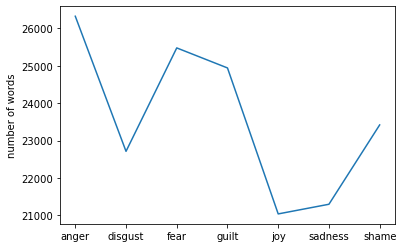

In [8]:
table = pd.pivot_table(df, values='Text_length', index=label, aggfunc=np.sum)
plt.plot(table)
plt.ylabel('number of words')

**What is remarkable here is that people often wirte more when then express feeling of anger and write less when they joyed**

In [9]:
# Prepare For Modeling by Pre-Processing Data

In [10]:
# check for duplication and drop them
print(df.duplicated().sum())
df=df.drop_duplicates()



58


In [11]:

df['label'].value_counts()


anger      1080
joy        1073
fear       1071
disgust    1056
sadness    1052
guilt      1052
shame      1038
Name: label, dtype: int64

In [12]:
stopword=set(stopwords.words('english'))

ps = PorterStemmer() 
lem = WordNetLemmatizer()

def preprocess_tweet(text):
    
    text=text.lower()    
    text_words=word_tokenize(text) 
    filtered_sent=[]
    for w in text_words:
        if w not in stopword:
            filtered_sent.append(w)

    stemmed_words=[]
    for w in filtered_sent:
       stemmed_words.append(ps.stem(w))
       
    lemmatized_words=[]
    for w in stemmed_words:
       lemmatized_words.append(lem.lemmatize(w))     
    text=lemmatized_words
    return(text)
textSimple=[preprocess_tweet(line) for line in text ]


In [13]:
df = pd.DataFrame({'label':label,'text':textSimple})
print(df.head(20))

      label                                               text
0       joy  [period, fall, love, time, met, especi, met, l...
1      fear                           [involv, traffic, accid]
2     anger  [drive, home, sever, day, hard, work, motorist...
3   sadness                              [lost, person, meant]
4   disgust  [time, knock, deer, sight, anim, injuri, helpl...
5     shame                                     [speak, truth]
6     guilt  [caus, problem, somebodi, could, keep, appoint...
7       joy           [got, letter, offer, summer, job, appli]
8      fear  [go, home, alon, one, night, pari, man, came, ...
9     anger  [talk, parti, first, time, long, friend, came,...
10  sadness                [friend, ask, go, new, year, parti]
11  disgust  [saw, drunk, kid, year, old, town, walpurgi, n...
12    shame  [could, rememb, say, present, task, account, m...
13    guilt       [uncl, neighbour, came, home, polic, escort]
14      joy  [day, feel, close, partner, friend, feel, 

In [14]:

# class distribution
print(df.groupby('label').size())

label
anger      1080
disgust    1057
fear       1078
guilt      1057
joy        1084
sadness    1079
shame      1045
dtype: int64


In [15]:
df['text']=[" ".join(review) for review in df['text'].values]


In [16]:
data =np.array(df.text.values)
label =np.array(df.label.values)


In [17]:
# Build Models


In [18]:
# looking for best n gram 
for i in [(1, 1),(1, 2),(1, 3),(2, 2),(2, 3)]:
    tfv=TfidfVectorizer(sublinear_tf=True,ngram_range=i)
    X=tfv.fit_transform(data)
    lbl = LabelEncoder()
    y = lbl.fit_transform(label)
    X_train , X_test ,y_train, y_test= train_test_split(X,y,test_size=0.2)
    rfc =RandomForestClassifier()
    rfc.fit(X_train,y_train)
    pred =rfc.predict(X_test)
    print(f'Accuracy for Random Forest on CV data:for ngram {i}the accuracy is',accuracy_score(y_test,pred))


Accuracy for Random Forest on CV data:for ngram (1, 1)the accuracy is 0.5421122994652406
Accuracy for Random Forest on CV data:for ngram (1, 2)the accuracy is 0.5741978609625669
Accuracy for Random Forest on CV data:for ngram (1, 3)the accuracy is 0.5581550802139037
Accuracy for Random Forest on CV data:for ngram (2, 2)the accuracy is 0.3810160427807487
Accuracy for Random Forest on CV data:for ngram (2, 3)the accuracy is 0.3669786096256685


In [33]:
tfv=TfidfVectorizer(sublinear_tf=True,ngram_range=(1, 2),max_features=5000)
X=tfv.fit_transform(data)


In [34]:
lbl = LabelEncoder()

y = lbl.fit_transform(label) 


In [35]:
label

array(['joy', 'fear', 'anger', ..., 'disgust', 'shame', 'guilt'],
      dtype=object)

In [36]:

X_train , X_test ,y_train, y_test= train_test_split(X,y,test_size=0.1)


In [37]:
print(X_train.shape)
print(X_test.shape)

(6732, 5000)
(748, 5000)


In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Ridge,LinearRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB

In [43]:
# Spot Check Algorithms
models = []
models.append(('LSVC', LinearSVC()))
models.append(('RFC', RandomForestClassifier()))
models.append(('KNC', KNeighborsClassifier( )))
models.append(('DTC', DecisionTreeClassifier( )))
models.append(('GBC', GradientBoostingClassifier( )))
models.append(('MLPC', MLPClassifier( )))





In [44]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LSVC: 0.569515 (0.018493)
RFC: 0.559416 (0.010992)
KNC: 0.405967 (0.015471)
DTC: 0.477568 (0.011970)
GBC: 0.541150 (0.017439)
MLPC: 0.510989 (0.014142)


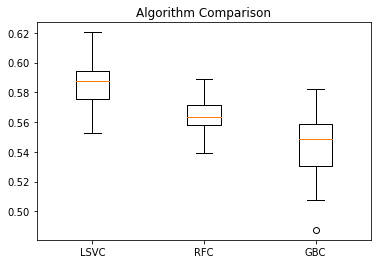

In [42]:
# Compare Algorithms
from matplotlib import pyplot

pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [ ]:
# tuning the tow best model 

In [45]:
lsvc=LinearSVC(max_iter= 500)
lsvc.fit(X_train,y_train)
pred_lsvc =lsvc.predict(X_test)


In [46]:
rfc =RandomForestClassifier()
param_grid = { 
    'n_estimators': [400,500, 600,700,800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [11,12,13,14,15],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [11, 12, 13, 14, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [400, 500, 600, 700, 800]})

In [47]:
CV_rfc.best_params_


{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'log2',
 'n_estimators': 800}

In [48]:
rfc =RandomForestClassifier(criterion='entropy',max_depth=15,max_features='log2',n_estimators= 800)


In [49]:
rfc.fit(X_train,y_train)
pred_rfc =rfc.predict(X_test)


In [50]:

print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred_rfc))


Accuracy for Random Forest on CV data:  0.5320855614973262


In [54]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred_lsvc))


Accuracy for Random Forest on CV data:  0.5374331550802139


In [56]:

cmconfusion_matrix
cm_analysis(y_test,pred_rfc)

NameError: name 'cm_analysis' is not defined

In [82]:
x = tfv.transform(['i hate you' ])
t = rfc.predict(x)


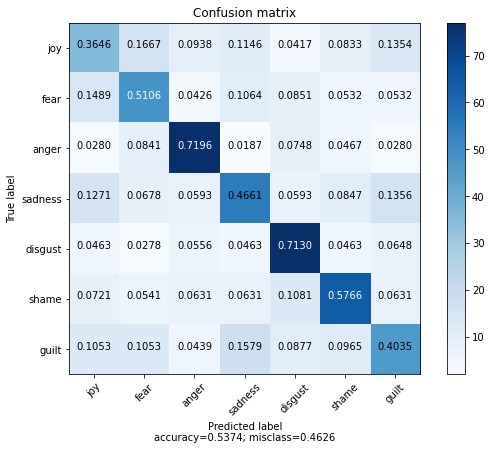

In [58]:

cm1 =confusion_matrix(y_test,pred_lsvc)
cm2 =confusion_matrix(y_test,pred_rfc)

plot_confusion_matrix(cm1,emotions)


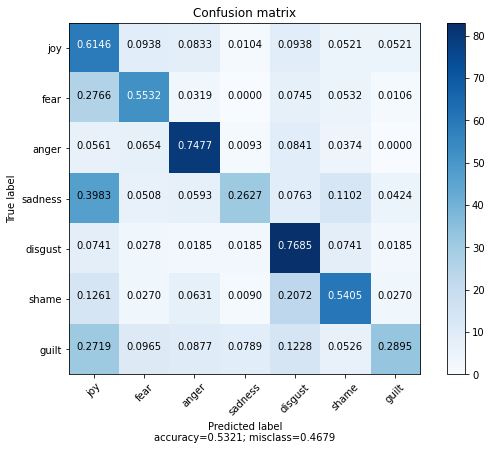

In [59]:
plot_confusion_matrix(cm2,emotions)

In [ ]:
# testing the model 

In [68]:
text = ['i love you' , 'i hate you', ' i feel sad']
x = tfv.transform(text)
t = rfc.predict(x)

In [69]:
t= lbl.inverse_transform(t)

In [70]:
t

array(['joy', 'anger', 'sadness'], dtype=object)